In [3]:
# !pip install mqt.bench
import lovelyplots
import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rx
import scienceplots

# !pip install adjustText
# from adjustText import adjust_text
from mqt.bench import CompilerSettings, QiskitSettings, TKETSettings, get_benchmark


from qiskit import qasm2, transpile
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import CouplingMap
from rustworkx.visualization import graphviz_draw, mpl_draw
from tqdm.notebook import tqdm

from corral_crowding import sqiswap  # update global equivalence library
from corral_crowding.topologies import (
    build_graphs,
    corral,
    denselattice,
    hex_topo,
    ring,
    square,
    tworing,
)
from itertools import chain


In [4]:
# need to load the mqt and qasm bench cirucits into qiskit
qasmbench = [
    "../qasmbench/multiplier_n15.qasm",
    "../qasmbench/sat_n11.qasm",
]
mqt_bench_names = [
    "ae",
    "qft",
    "qnn",
    "qpeexact",
    "su2random",
    "realamprandom",
]


def get_benchmarks():
    benchmarks = {}
    for benchmark_name in chain(qasmbench, mqt_bench_names):
        # print(f"  Processing circuit: {benchmark_name}")
        if benchmark_name in qasmbench:
            input_qc = qasm2.load(benchmark_name)
        elif benchmark_name in mqt_bench_names:
            input_qc = get_benchmark(
                benchmark_name=benchmark_name, level="alg", circuit_size=16
            )
        else:
            raise ValueError(f"Unknown benchmark name: {benchmark_name}")

        if benchmark_name == "../qasmbench/multiplier_n15.qasm":
            benchmark_name = "multiplier"
        elif benchmark_name == "../qasmbench/sat_n11.qasm":
            benchmark_name = "sat"
        benchmarks[benchmark_name] = input_qc
    return benchmarks


def transpile_benchmarks(input_qc, qubit_connectivity):
    isa = "cx"

    # Transpile without basis gates
    tqc1 = transpile(input_qc, coupling_map=qubit_connectivity)
    tqc1_ops = tqc1.count_ops()
    tqc1_longest_path_ops = circuit_to_dag(tqc1).count_ops_longest_path()

    swap_count = tqc1_ops.get("swap", 0)
    swap_longest_path = tqc1_longest_path_ops.get("swap", 0)

    # Transpile with xx_plus_yy basis gates
    tqc2 = transpile(
        input_qc,
        coupling_map=qubit_connectivity,
        basis_gates=["u3", isa],
    )
    tqc2_ops = tqc2.count_ops()
    tqc2_longest_path_ops = circuit_to_dag(tqc2).count_ops_longest_path()

    two_qubit_gate_count = tqc2_ops.get(isa, 0)
    two_qubit_longest_path = tqc2_longest_path_ops.get(isa, 0)
    return (
        swap_count,
        swap_longest_path,
        two_qubit_gate_count,
        two_qubit_longest_path,
    )

In [5]:
# need to load all the topologies into CouplingMaps
# each topology should have a average gate fidelity
# each topology gets a variant with 1 edge deleted, but with a higher base gate fidelity
import networkx as nx
from corral_crowding.bipartite import plot_graphs
from corral_crowding.topologies import (
    ring,
    square,
    tworing,
    hex_topo,
    corral,
    denselattice,
    best,
)

qiskit_topologies = {}

names = [
    "ring",
    "hex",
    "corral",
    "best",
    "lattice",
]  # "denselattice","tworing","square",
# names = ["corral", "best"]
for i, topo in enumerate(
    [ring, hex_topo, corral, best, square]  # tworing, square
):  # denselattice
    snails, qubits, edges = topo
    A_nodes = snails
    B_nodes = qubits
    G_rebuilt = nx.Graph()
    G_rebuilt.add_nodes_from(A_nodes, bipartite=0)
    G_rebuilt.add_nodes_from(B_nodes, bipartite=1)
    G_rebuilt.add_edges_from(edges)
    qubit_connectivty = nx.bipartite.projected_graph(G_rebuilt, B_nodes)
    cmap = CouplingMap(qubit_connectivty.edges())
    cmap.make_symmetric()
    qiskit_topologies[names[i]] = cmap

In [6]:
# line = CouplingMap.from_line(32)
heavyhex = CouplingMap.from_heavy_hex(3)
square = CouplingMap.from_grid(4, 4)
qiskit_topologies["heavyhex"] = heavyhex
qiskit_topologies["square"] = square

nx_edges = [
    (9, 10),
    (9, 11),
    (9, 12),
    (9, 15),
    (9, 18),
    (9, 21),
    (10, 11),
    (10, 13),
    (10, 16),
    (10, 19),
    (10, 21),
    (11, 14),
    (11, 17),
    (11, 20),
    (11, 21),
    (12, 13),
    (12, 14),
    (12, 15),
    (12, 18),
    (12, 22),
    (13, 14),
    (13, 16),
    (13, 19),
    (13, 22),
    (14, 17),
    (14, 20),
    (14, 22),
    (15, 16),
    (15, 17),
    (15, 18),
    (15, 23),
    (16, 17),
    (16, 19),
    (16, 23),
    (17, 20),
    (17, 23),
    (18, 19),
    (18, 20),
    (18, 24),
    (19, 20),
    (19, 24),
    (20, 24),
    (21, 22),
    (21, 23),
    (21, 24),
    (22, 23),
    (22, 24),
    (23, 24),
]
offset_edges = [(x - 9, y - 9) for x, y in nx_edges]
best = CouplingMap(offset_edges)
best.make_symmetric()
qiskit_topologies[r"best$_{k=0}$"] = best

nx_edges_k1 = [
    (9, 10),
    (9, 11),
    (9, 21),
    (9, 12),
    (9, 15),
    (9, 18),
    (10, 11),
    (10, 21),
    (10, 13),
    (10, 16),
    (10, 19),
    (11, 14),
    (11, 17),
    (11, 20),
    (12, 13),
    (12, 14),
    (12, 22),
    (12, 15),
    (12, 18),
    (13, 14),
    (13, 22),
    (13, 16),
    (13, 19),
    (14, 17),
    (14, 20),
    (15, 16),
    (15, 17),
    (15, 23),
    (16, 17),
    (16, 23),
    (18, 19),
    (18, 20),
    (18, 24),
    (19, 20),
    (19, 24),
    (21, 22),
    (21, 23),
    (21, 24),
    (22, 23),
    (22, 24),
]
offset_edges = [(x - 9, y - 9) for x, y in nx_edges_k1]
best = CouplingMap(offset_edges)
best.make_symmetric()
qiskit_topologies[r"best$_{k=1}$"] = best

nx_edges_k2 = [
    (9, 10),
    (9, 11),
    (9, 21),
    (9, 12),
    (9, 15),
    (9, 18),
    (10, 11),
    (10, 13),
    (10, 16),
    (10, 19),
    (11, 14),
    (11, 17),
    (11, 20),
    (12, 13),
    (12, 14),
    (12, 22),
    (12, 15),
    (13, 14),
    (13, 16),
    (14, 17),
    (15, 16),
    (15, 17),
    (15, 23),
    (16, 17),
    (18, 19),
    (18, 20),
    (18, 24),
    (19, 20),
    (21, 22),
    (21, 23),
    (21, 24),
    (22, 23),
]
offset_edges = [(x - 9, y - 9) for x, y in nx_edges_k2]
best = CouplingMap(offset_edges)
best.make_symmetric()
qiskit_topologies[r"best$_{k=2}$"] = best

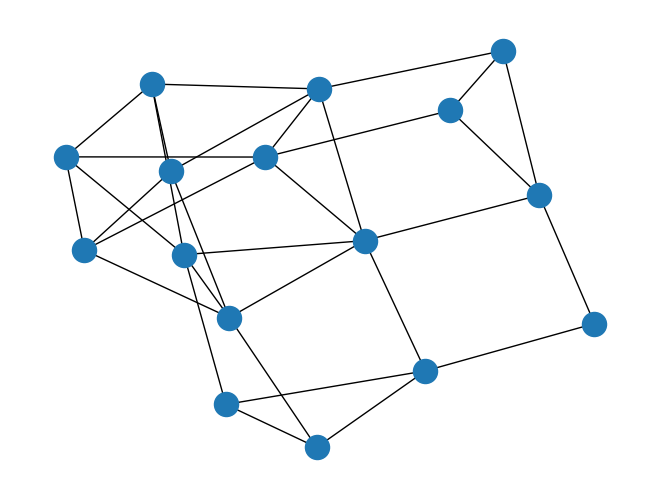

In [7]:
nx.draw_kamada_kawai(nx.Graph(offset_edges))

In [8]:
# put results in nested dict
# topology -> circuit -> metric -> value
circuit_benchmarks = get_benchmarks()
results = {}
for name, topo in qiskit_topologies.items():
    results[name] = {}
    for benchmark_name, circuit_benchmark in circuit_benchmarks.items():
        results[name][benchmark_name] = {}
        swap_count, swap_longest_path, two_qubit_gate_count, two_qubit_longest_path = (
            transpile_benchmarks(circuit_benchmark, topo)
        )
        results[name][benchmark_name]["swap_count"] = swap_count
        results[name][benchmark_name]["swap_longest_path"] = swap_longest_path
        results[name][benchmark_name]["two_qubit_gate_count"] = two_qubit_gate_count
        results[name][benchmark_name]["two_qubit_longest_path"] = two_qubit_longest_path

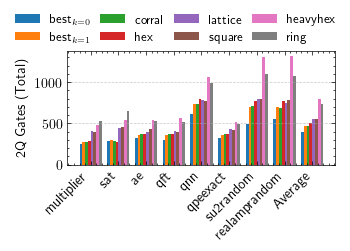

In [31]:
# Re-run the plot correctly, computing the average across benchmarks for each topology
import matplotlib.pyplot as plt
import numpy as np

# Define the sorted order of topologies
sorted_topologies = [
    "ring",
    "heavyhex",
    "square",
    "lattice",
    "hex",
    "corral",
    r"best$_{k=1}$",
    r"best$_{k=0}$",
]
sorted_topologies = list(reversed(sorted_topologies))  # Reverse to maintain order
benchmark_names = list(circuit_benchmarks.keys())

# Compute average over benchmarks for each topology
average_values = {
    topo: np.mean(
        [results[topo][bench]["two_qubit_gate_count"] for bench in benchmark_names]
    )
    for topo in sorted_topologies
}

# Define colors
colors = plt.cm.tab10(np.arange(len(sorted_topologies)))

# Create subplots with original formatting
with plt.style.context(["use_mathtext", "science"]):  # Removed "ieee" to prevent error
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(3.5, 2.2))

    width = 0.1  # Adjusted bar width for spacing
    x = np.arange(len(benchmark_names) + 1)  # Extra column for "Average"

    # Iterate through topologies in sorted order
    for j, (topo, color) in enumerate(zip(sorted_topologies, colors)):
        values = [
            results[topo][bench]["two_qubit_gate_count"] for bench in benchmark_names
        ]
        values.append(
            average_values[topo]
        )  # Append the computed average for each topology
        ax.bar(
            x + j * width,
            values,
            width=width,
            label=topo,
            color=color,
        )

    # Set X-axis labels
    ax.set_xticks(x + (len(sorted_topologies) * width) / 2 - width / 2)
    ax.set_xticklabels(benchmark_names + ["Average"], rotation=45, ha="right")

    # Labels and grid
    ax.set_ylabel("2Q Gates (Total)")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Add legend
    fig.legend(
        sorted_topologies,
        loc="upper center",
        ncol=4,
        bbox_to_anchor=(0.5, 1.15),
        columnspacing=0.75,
        fontsize=9,
    )

fig.savefig("2q_gates.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


In [10]:
# for topo in sorted_topologies:
#     print(topo)
#     print(results[topo]["qft"]["swap_count"])

In [11]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define gate fidelities per topology (example values, adjust as needed)
# gate_fidelities = {
#     "ring": 0.99,
#     "tworing": 0.99,
#     "heavyhex": 0.99,
#     "hex_topo": 99,
#     "denselattice": 0.99,
#     "corral": 0.99,
#     "best": 0.99,
#     "square": 0.99,
# }

# # Compute fidelity approximations
# fidelity_results = {}
# for topo, benchmarks in results.items():
#     fidelity_results[topo] = {}
#     gate_fidelity = gate_fidelities[topo]

#     for benchmark_name, metrics in benchmarks.items():
#         # Fidelity approximation: (gate fidelity)^num_two_qubit_gates
#         two_qubit_gates = metrics["two_qubit_gate_count"]
#         fidelity_approx = gate_fidelity**two_qubit_gates
#         fidelity_results[topo][benchmark_name] = fidelity_approx

# # Plot fidelity approximations
# fig, ax = plt.subplots(figsize=(8, 5))
# width = 0.1  # Bar width
# x = np.arange(len(benchmark_names))  # X-axis positions

# for j, topo in enumerate(topologies):
#     fidelities = [fidelity_results[topo][bench] for bench in benchmark_names]
#     ax.bar(
#         x + j * width,
#         fidelities,
#         width=width,
#         label=topo,
#         color=topo_colors.get(topo, "gray"),
#     )

# ax.set_xticks(x + (len(topologies) * width) / 2)
# ax.set_xticklabels(benchmark_names, rotation=45, ha="right")
# ax.set_title("Approximate Circuit Fidelity by Topology")
# ax.set_ylabel("Approximate Fidelity")
# ax.set_ylim(0, 1.05)  # Ensure fidelity stays within [0,1]
# ax.grid(axis="y", linestyle="--", alpha=0.7)

# # Add legend
# fig.legend(
#     topologies, loc="upper center", ncol=len(topologies), bbox_to_anchor=(0.5, 1.05)
# )
# plt.tight_layout()
# plt.show()


heavyhex 0.19529472378876234
ring 0.2042758020926135
hex 0.1222670877107593
square 0.16302405694760003
lattice 0.16365029719250163
corral 0.11686693316161512
best$_{k=1}$ 0.11493765616880129
best$_{k=0}$ 0.0872245255986845
heavyhex 0.09369834385450979
ring 0.08655909125436763
hex 0.07028184083700184
square 0.08327124574726247
lattice 0.0851450892069878
corral 0.061041351184274825
best$_{k=1}$ 0.0673958806182365
best$_{k=0}$ 0.04865588768716174


/tmp/ipykernel_226113/675642793.py:112: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


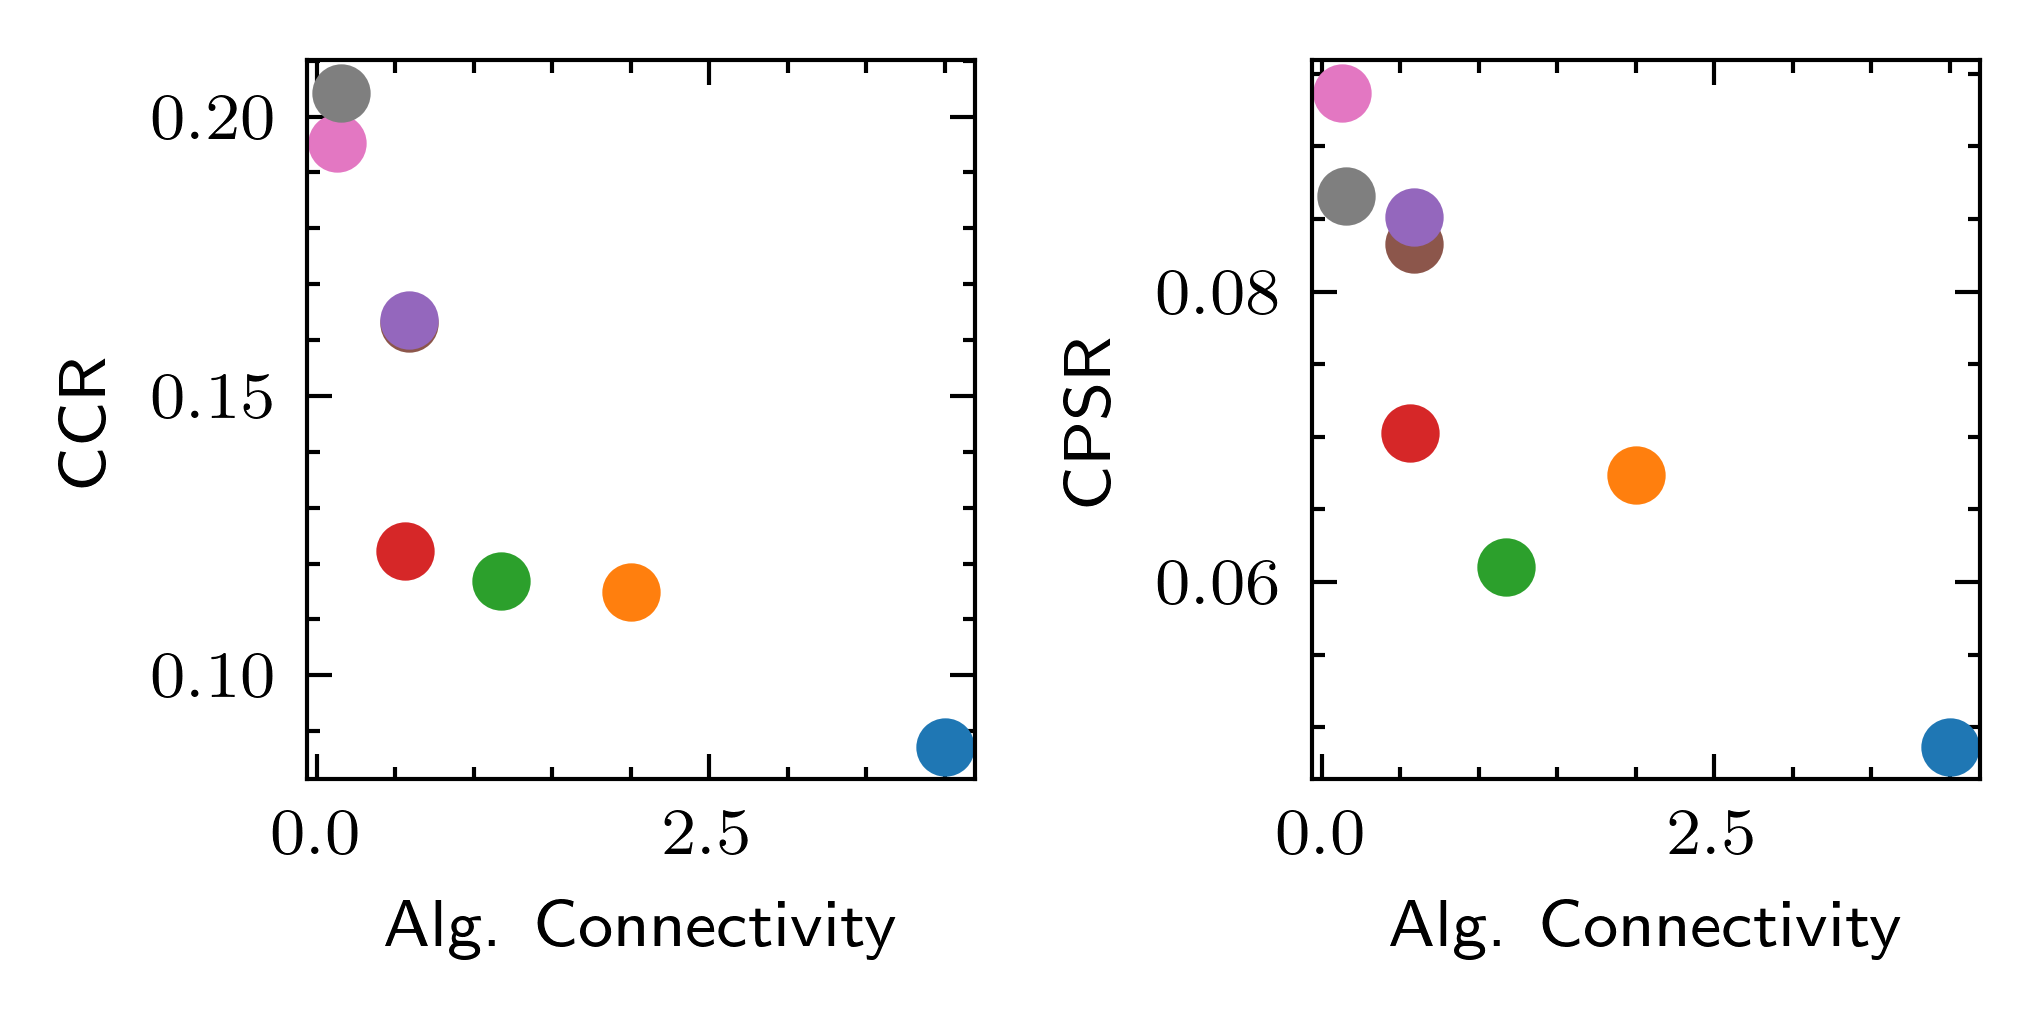

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Define the sorted order for topologies and their colors
sorted_topologies = [
    "ring",
    "heavyhex",
    "square",
    "lattice",
    "hex",
    "corral",
    # r"best$_{k=2}$",
    r"best$_{k=1}$",
    r"best$_{k=0}$",
]
topo_colors = {
    "ring": "tab:gray",
    "heavyhex": "tab:pink",
    "square": "tab:brown",
    "lattice": "tab:purple",
    "hex": "tab:red",
    "corral": "tab:green",
    # r"best$_{k=2}$": "tab:green",
    r"best$_{k=1}$": "tab:orange",
    r"best$_{k=0}$": "tab:blue",
}

# Initialize storage for data
ccr_values = []
ccr_critical_values = []
connectivity_values = []

# Extract benchmark names
benchmark_names = list(circuit_benchmarks.keys())

# Compute CCR, CCR_critical, and Algebraic Connectivity for each topology
for topo in sorted_topologies:
    # Compute Algebraic Connectivity
    G_B = qiskit_topologies[topo]  # Assuming G_B is stored in qiskit_topologies
    G_B = nx.Graph(list(G_B.get_edges()))
    connectivity = nx.algebraic_connectivity(G_B)
    connectivity_values.append(connectivity)

    # Compute CCR (Averaged over benchmarks)
    swap_counts = np.array(
        [results[topo][bench]["swap_count"] for bench in benchmark_names]
    )
    total_gate_counts = (
        np.array(
            [results[topo][bench]["two_qubit_gate_count"] for bench in benchmark_names]
        )
        + swap_counts
    )
    avg_ccr = np.mean(swap_counts / total_gate_counts)  # CCR = num_swaps / num_total
    ccr_values.append(avg_ccr)

    # Critical path swap ratio ( communication bottleneck intensity)
    swap_critical_counts = np.array(
        [results[topo][bench]["swap_longest_path"] for bench in benchmark_names]
    )
    total_critical_counts = (
        np.array(
            [results[topo][bench]["two_qubit_gate_count"] for bench in benchmark_names]
        )
        + swap_critical_counts
    )
    avg_ccr_critical = np.mean(
        swap_critical_counts / total_critical_counts
    )  # CCR_critical = swaps on critical path / total gates on critical path
    ccr_critical_values.append(avg_ccr_critical)

# Sort by algebraic connectivity
sorted_indices = np.argsort(connectivity_values)
connectivity_values = np.array(connectivity_values)[sorted_indices]
ccr_values = np.array(ccr_values)[sorted_indices]
ccr_critical_values = np.array(ccr_critical_values)[sorted_indices]
sorted_topologies = np.array(sorted_topologies)[sorted_indices]

# Create side-by-side scatter plots with colors
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, axes = plt.subplots(1, 2, figsize=(3.5, 1.8), constrained_layout=True)

    # Left: CCR vs. Connectivity
    for i, topo in enumerate(sorted_topologies):
        print(topo, ccr_values[i])
        axes[0].plot(
            connectivity_values[i],
            ccr_values[i],
            marker="o",
            linestyle="-",
            color=topo_colors[topo],
            label=topo,
        )
    axes[0].set_xlabel("Alg. Connectivity")
    axes[0].set_ylabel("CCR")

    # Right: CCR_critical vs. Connectivity
    for i, topo in enumerate(sorted_topologies):
        print(topo, ccr_critical_values[i])
        axes[1].plot(
            connectivity_values[i],
            ccr_critical_values[i],
            marker="o",
            linestyle="-",
            color=topo_colors[topo],
            label=topo,
        )
    axes[1].set_xlabel("Alg. Connectivity")
    axes[1].set_ylabel("CPSR")

plt.tight_layout()
plt.savefig("ccr_vs_ccr_critical_connectivity.pdf", bbox_inches="tight")
plt.show()


0.5972728573194989
0.6858602907362134
0.7161378141912594


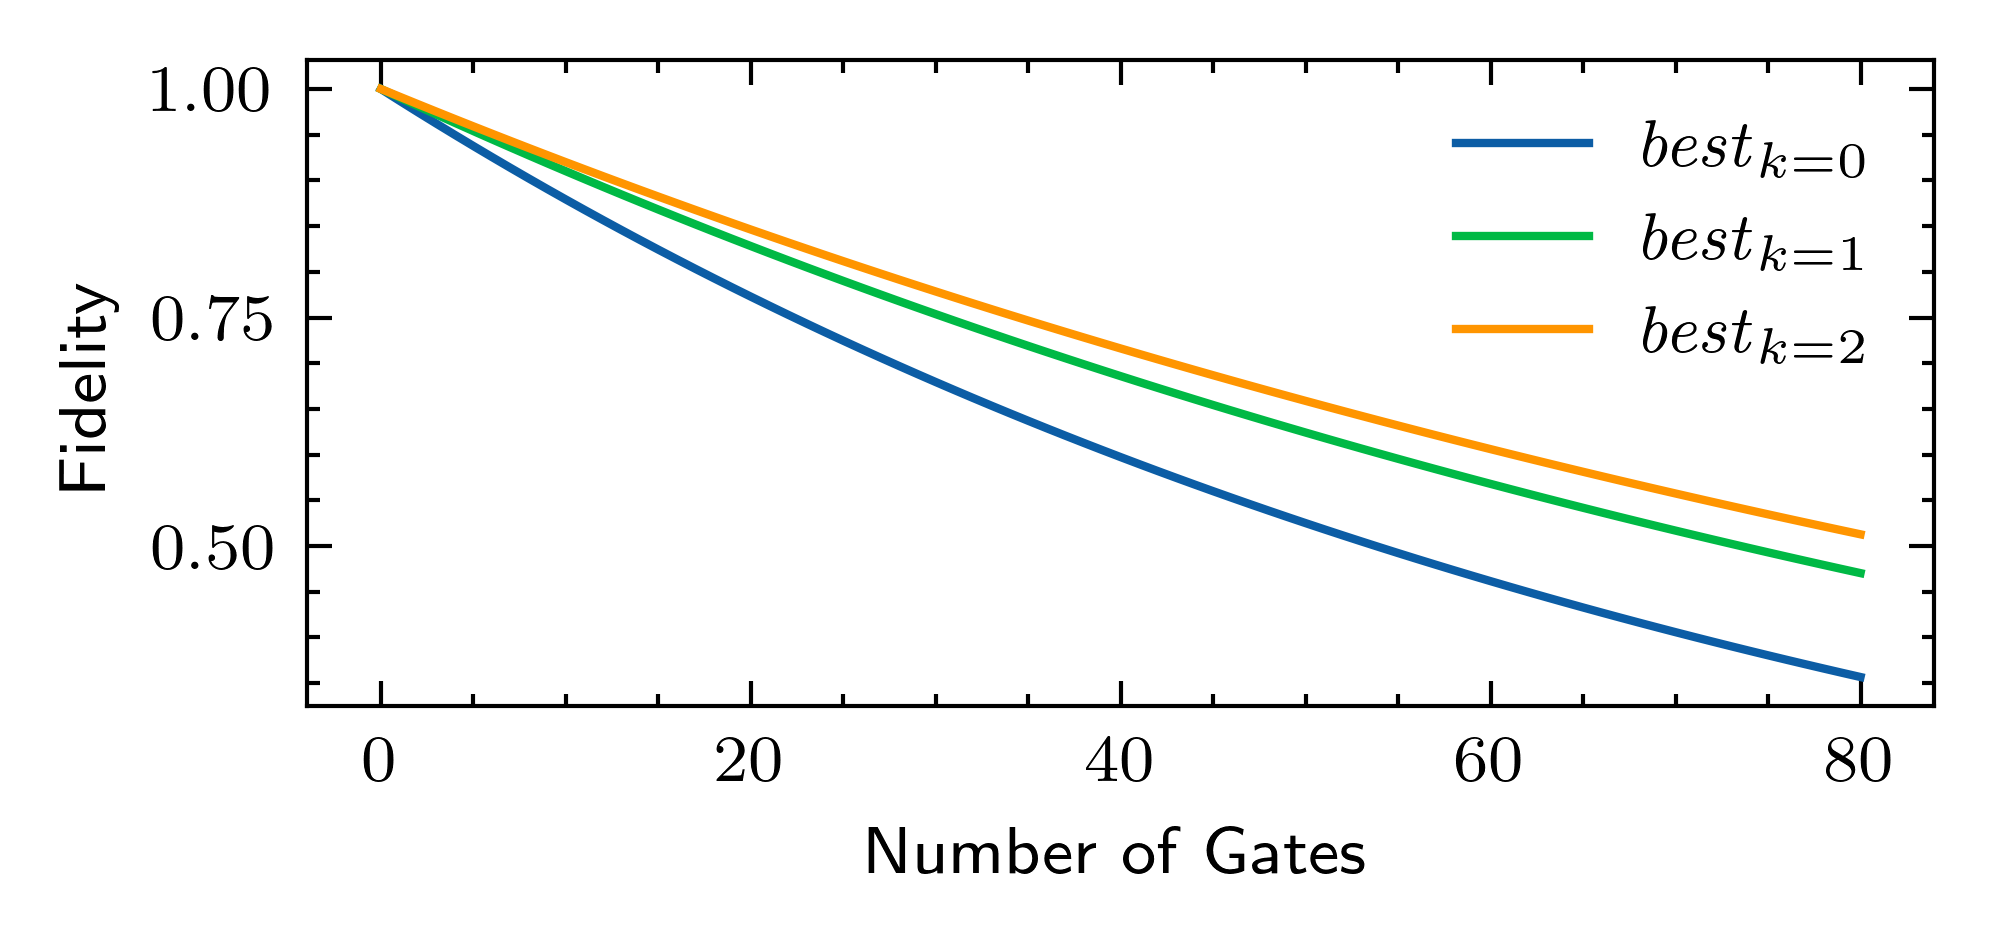

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
num_gates = np.arange(0, 81, 1)  # Range of gate counts from 0 to 80

labels = [r"$\mathit{best}_{k=0}$", r"$\mathit{best}_{k=1}$", r"$\mathit{best}_{k=2}$"]
CCR_values = [0.094, 0.114, 0.129]
F_gate_values = [0.99, 0.993, 0.994]

# Compute fidelity curves
fidelity_curves = {}


def fid(F_gate, CCR, num_gates):
    return (1 - (1 - F_gate)) ** ((1 + 3 * CCR) * num_gates)


print(fid(0.99, 0.094, 40))
print(fid(0.993, 0.114, 40))
print(fid(0.994, 0.129, 40))

for label, CCR, F_gate in zip(labels, CCR_values, F_gate_values):
    fidelity_curves[label] = fid(F_gate, CCR, num_gates)

# Plot raw data and damped decay fits
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 1.4))

    for label, fidelity in fidelity_curves.items():
        ax.plot(num_gates, fidelity, label=label)

    ax.set_xlabel("Number of Gates")
    ax.set_ylabel("Fidelity")
    ax.legend()

# plt.tight_layout()
plt.savefig("fidelity_curves.pdf", bbox_inches="tight")
plt.show()
